In [1]:
# Insérez ici le numéro de votre équipe
VOTRE_NUMERO_EQUIPE = 4
VOTRE_NUMERO_DINGO = 2
SIM = False

In [2]:
# Import des paquets requis et configuration du ROS Master
import sys
sys.path.append('/opt/ros/noetic/lib/python3/dist-packages/')
sys.path.append('/usr/lib/python3/dist-packages')
from os import environ
if SIM:
    environ['ROS_MASTER_URI'] = "http://localhost:1137{}/".format(VOTRE_NUMERO_EQUIPE)
else:
    environ['ROS_MASTER_URI'] = "http://cpr-ets05-0{}:11311/".format(VOTRE_NUMERO_DINGO)
    environ['ROS_IP'] = "192.168.0.84" # adresse IP de votre station de travail
import numpy as np
import rospy
from scipy.spatial.transform import Rotation as R
from math import sin, cos
from jackal_msgs.msg import Feedback
from jackal_msgs.msg import Drive
from sensor_msgs.msg import Imu
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Quaternion, Twist, Vector3
from filterpy.kalman import ExtendedKalmanFilter
#from lab_utils.project2 import publish_odom_tf

In [3]:
# Créer et démarrer un nouveau noeud
rospy.init_node('dingo_state_estimation', anonymous=True)

In [4]:
# Fonction pour le calcul de l'orientation à partir d'un quaternion
# Entrée : Quaternion [x, y ,z ,w]
# Sortie : Angle de lacet (yaw) en radians
def get_heading_from_quaternion(q):
    r = R.from_quat([q.x, q.y, q.z, q.w])
    angles = r.as_euler('xyz', degrees=False)
    return angles[2]

In [5]:
# Ground truth subscriber callback
ground_truth_msg = Odometry()
def ground_truth_callback(msg):
    global ground_truth_msg
    ground_truth_msg = msg

### Configuration du script

Ajoutez ici les données géométriques du robot

In [6]:
# À compléter selon les tâches précédentes
interwheel_distance = 0.46
left_wheel_radius = 0.045
right_wheel_radius = 0.045
var_encodeur_gauche = 0.00207188799341715 #Fichier CSV-analyse-commande
var_encodeur_droit = 0.0019638318193607386 #Fichier CSV-analyse-commande
var_theta = 2.4822889213457126e-05 #Fichier CSV-analyse-commande
var_omega = 2.4238010829617694e-05 #Fichier CSV-analyse-commande
var_acc_x = 2.436761908318059e-05 #Fichier CSV-analyse-commande
var_acc_y = 2.4522669777637666e-05 #Fichier CSV-analyse-commande

### Estimer les déplacements du robot

Dans la prochaine cellule ajoutez votre code pour estimer les variables x, y et theta du robot (et leurs vitesses).

In [7]:
# Dans cette fonction la variable msg contient les mesures de l'UMI
def imu_callback(msg):
    
    # Récupération des données de l'IMU
    acc_x = msg.linear_acceleration.x
    acc_y = msg.linear_acceleration.y
    omega = msg.angular_velocity.z
    
    # Initialisation du vecteur de mesures
    z = np.array([[np.sqrt(acc_x**2+acc_y**2)],
                  [omega]])
    
    # Initialisation du timestamp
    timestamp = rospy.get_time()
    # Appel du filtre
    kf_pre_update(z, timestamp)
    
# Dans cette fonction la variable msg contient les mesures des encodeurs
def encoders_callback(msg):
    
    # Initialisation du vecteur de commande en variable globale
    global u
    
    # Initialisation des vitesses linéaire des roues en fonction des vitesses angulaires récupérées dans msg
    vr  = msg.drivers[1].measured_velocity*right_wheel_radius
    vl  = msg.drivers[0].measured_velocity*left_wheel_radius
    
    # Vecteur de commande u
    u = np.array([[vr],[vl]])
    

### Construire le filtre

Dans la prochaine cellule utiliser la bibliothèque FilterPy pour construire le filtre Kalman et estimer le déplacement du robot à partir des capteurs

Vous devez concevoir votre filtre et prendre en compte plusieurs éléments par exemple : nombre d'états, nombre de commandes, nombre de mesures, synchrone ou asynchrone, KF ou EKF, etc.
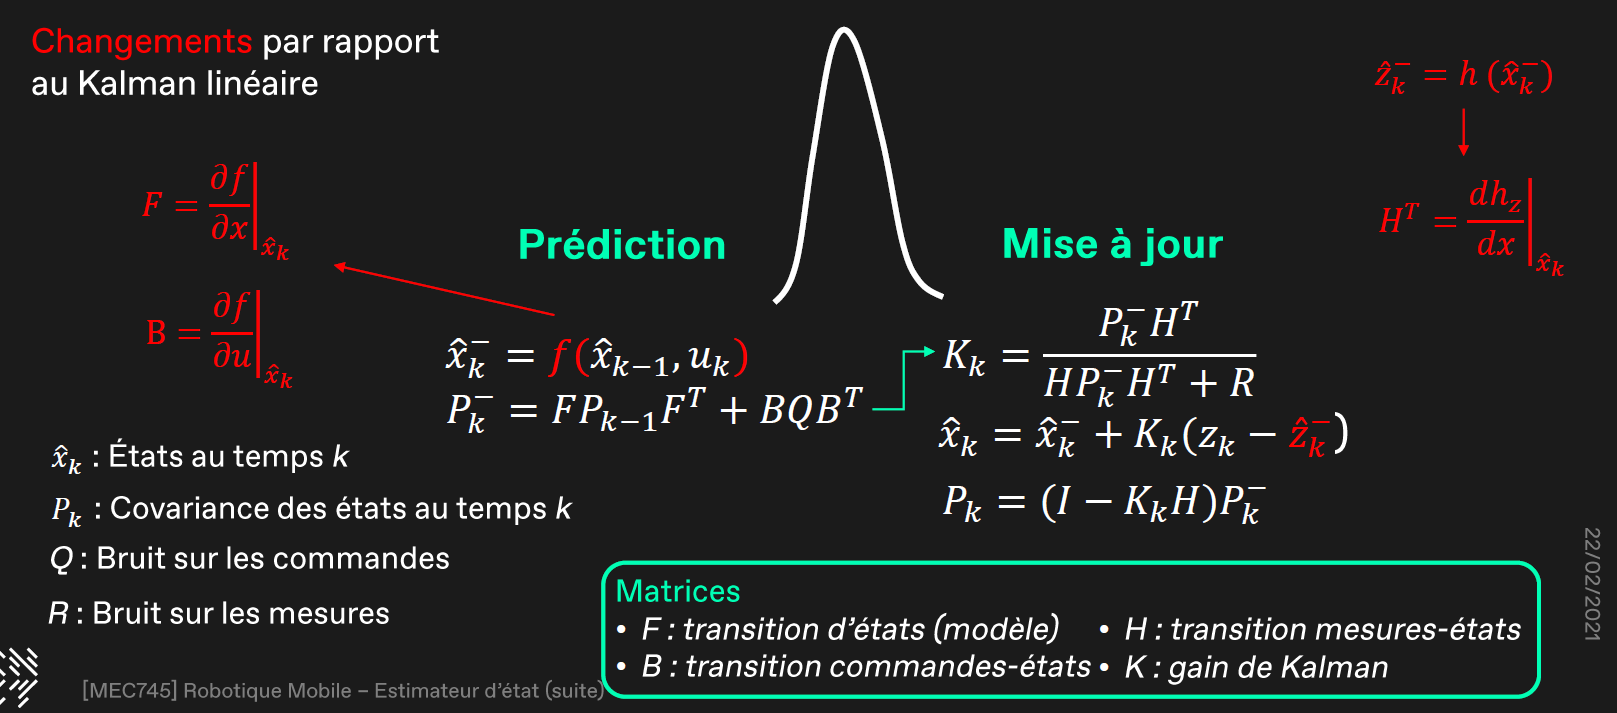

In [8]:
# Initialisation des dimensions
dim_x = 6
dim_z = 2
dim_u = 2

# Création du filtre Kalman - dimensions x et z initialisées (changez le 0 selon votre utilisation)
kf = ExtendedKalmanFilter(dim_x, dim_z, dim_u)

# Initialisation du vecteur d'état proche de 0 pour éviter les division par 0
for i in range(0, len(kf.x)):
    kf.x[i] = 0.00000001
    
'''Rappel de la signification du vecteur x et du vecteur u
kf.x[1] = Position x
kf.x[2] = Accélèration x
kf.x[3] = Position y
kf.x[4] = Accélèration y
kf.x[5] = Angle theta
kf.x[6] = Vitesse angulaire omega

u[0] = vd = vr
u[1] = vg = vl
'''

# Fonction pour le calcul du vecteur de transition mesurures-états
def Hx(x):
    acc_x_global = float(kf.x[1])
    acc_y_global = float(kf.x[3])
    
    return np.array([[np.sqrt(acc_x_global**2+acc_y_global**2)],
                     [float(kf.x[5])]
                    ])

# Fonction pour le calcul de la matrice jacobienne de transition mesurures-états (Linéarisation de Hx)
def HJacobian(x):
    acc_x_global = float(kf.x[1])
    acc_y_global = float(kf.x[3])

    Hj_t = np.array([[0, acc_x_global/(np.sqrt(acc_x_global**2+acc_y_global**2)), 0, acc_y_global/(np.sqrt(acc_x_global**2+acc_y_global**2)), 0, 0],
                     [0, 0, 0, 0, 0, 1]
                    ])
    return Hj_t

'''fonction filtre de Kalman non linéaire'''
def kf_pre_update(z, timestamp):
    global last_measurement_time

    if timestamp > last_measurement_time:
        dt = timestamp - last_measurement_time
        last_measurement_time = timestamp
        
        '''Définition de la matrice de transition d'état F '''
        kf.F = np.array([[1, (dt**2)/2, 0,         0, float(-((u[0]+u[1])/2)*dt*sin(kf.x[4])), 0], #l1
                         [0,         1, 0,         0,                                       0, 0], #l2
                         [0,         0, 1, (dt**2)/2,  float(((u[0]+u[1])/2)*dt*cos(kf.x[4])), 0], #l3
                         [0,         0, 0,         1,                                       0, 0], #l4
                         [0,         0, 0,         0,                                       1, 0], #l5
                         [0,         0, 0,         0,                                       0, 1]  #l6
                        ])        
        '''Définition de la matrice de transition commandes-états F '''
        kf.B = np.array([[dt*cos(kf.x[4])/2      ,dt*cos(kf.x[4])/2      ],
                         [0                      ,0                      ],
                         [dt*sin(kf.x[4])/2      ,dt*sin(kf.x[4])/2      ],
                         [0                      ,0                      ],
                         [dt/interwheel_distance ,-dt/interwheel_distance],
                         [0                      ,0                      ] 
                        ])

        
        # Matrice de bruit sur les commandes
        Q = np.array([[var_encodeur_gauche,                     0],
                      [0                  , var_encodeur_droit   ]
                     ])
        #Pour la bibliothèque filterpy: Q = BQB^t
        kf.Q = np.dot(np.dot(kf.B,Q), np.transpose(kf.B))
        
        #Matrice de bruit sur les mesures 
        #/!\ Pour le calcul de la variance, voir la formule de propagation des erreurs ci-dessous
        kf.R = np.array([[((var_acc_x)+(var_acc_y))/4,                      0],
                         [0                          ,              var_omega],
                        ])     
        
        # Mise a jour du FIltre de Kalman
        kf.predict_update(z, HJacobian, Hx, u=u)
        
        
    else:
        pass

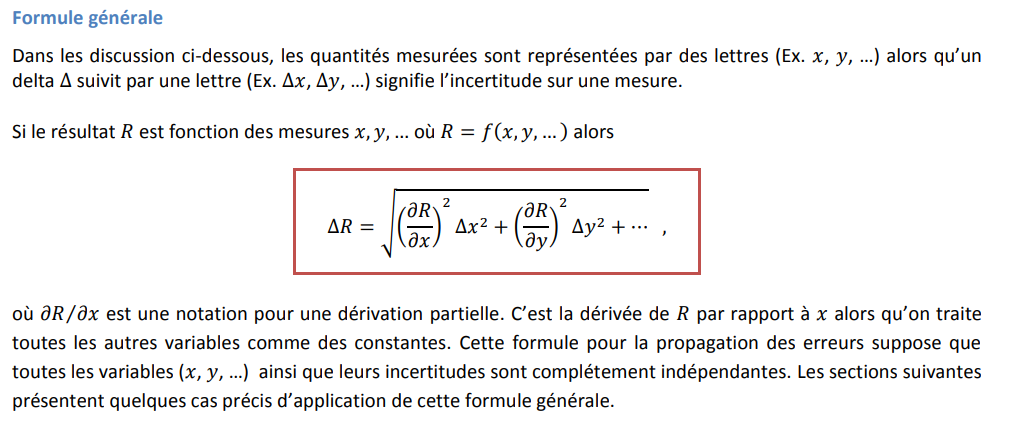
### Configuration du script

Ajoutez ici les noms des messages ROS

In [9]:
# ROS subscribers et publishers
ground_truth_sub = rospy.Subscriber('mobile_manip/t265/odom/sample', Odometry, ground_truth_callback)

# Temps de la simulation pour le calcul de dt
last_measurement_time = rospy.get_time()

if SIM:
    imu_sub = rospy.Subscriber('imu/data', Imu, imu_callback)
    cmd_drive_pub = rospy.Publisher('mobile_manip/dingo_velocity_controller/cmd_drive', Drive, queue_size=1)
    feedback_sub = rospy.Subscriber('mobile_manip/dingo_velocity_controller/feedback', Feedback, encoders_callback)
else:
    imu_sub = rospy.Subscriber('mobile_manip/base/imu/data', Imu, imu_callback)
    cmd_drive_pub = rospy.Publisher('mobile_manip/base/dingo_velocity_controller/cmd_drive', Drive, queue_size=1)
    feedback_sub = rospy.Subscriber('mobile_manip/base/dingo_velocity_controller/feedback', Feedback, encoders_callback)

### Tester le filtre

La prochaine cellule déplace le robot dans une courbe pour 20 secondes et enregistre sa pose réelle la pose estimée dans un rosbag.

Changez les 0 pour les valeurs correspondantes de votre filtre Kalman.

In [10]:
# Création d'un nouveau contenant ROSBAG (en écriture)
import rosbag
test_bag = rosbag.Bag('project2.bag', 'w')

# Publie l'odométrie et la TF pendant 20 secondes
start = float(rospy.Time().now().secs)
rate = rospy.Rate(50) # 50hz
while (float(rospy.Time().now().secs) - start) < 20:
    
    # ***TÂCHE***
    # Remplissez avec les valeurs correspondantes de votre filtre Kalman (états)
    # exemple x = kf.x[0]
    x = float(kf.x[0])
    y = float(kf.x[2])
    vlin = (u[0]+u[1])/2
    vang = float(kf.x[5])
    theta = float(kf.x[4])
    
    # ***TÂCHE***

    # Déplacer le robot
    cmd_drive_msg = Drive()
    cmd_drive_msg.drivers[0] = 5.0
    cmd_drive_msg.drivers[1] = 7.0
    cmd_drive_pub.publish(cmd_drive_msg)
    
    # Enregistrer le déplacement du robot
    pose = (x, y, 0)
    r = R.from_euler('xyz', [0, 0, theta], degrees=False)
    orientation = r.as_quat()
    odometry_msg = Odometry()
    odometry_msg.header.frame_id = "odom"
    odometry_msg.header.stamp = rospy.Time.now()
    odometry_msg.child_frame_id = "base_link"
    odometry_msg.pose.pose = Pose(Point(*pose), Quaternion(*orientation))
    odometry_msg.twist.twist = Twist(Vector3(vlin, 0, 0), Vector3(0, 0, vang))
    
    test_bag.write('/filter', odometry_msg, rospy.Time().now())
    test_bag.write('/ground_truth', ground_truth_msg, rospy.Time().now())
    rate.sleep()
    
# fermer proprement le ROSBAG
test_bag.close()

In [11]:
# Arreter le dingo
cmd_drive_msg = Drive()
cmd_drive_msg.drivers[0] = 0.0
cmd_drive_msg.drivers[1] = 0.0
cmd_drive_pub.publish(cmd_drive_msg)